In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.metrics import mean_absolute_percentage_error 
import warnings 
warnings.filterwarnings("ignore")


In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [3]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM,Dense 
from sklearn.preprocessing import MinMaxScaler

In [4]:
# reading the pizza sales dataset 
sales=pd.read_csv('Pizza_Sale - pizza_sales.csv')

In [5]:
sales.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,1/1/2015,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,1/1/2015,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,1/1/2015,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,1/1/2015,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,1/1/2015,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [6]:
sales.shape

(48620, 12)

In [7]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pizza_id           48620 non-null  int64  
 1   order_id           48620 non-null  int64  
 2   pizza_name_id      48604 non-null  object 
 3   quantity           48620 non-null  int64  
 4   order_date         48620 non-null  object 
 5   order_time         48620 non-null  object 
 6   unit_price         48620 non-null  float64
 7   total_price        48613 non-null  float64
 8   pizza_size         48620 non-null  object 
 9   pizza_category     48597 non-null  object 
 10  pizza_ingredients  48607 non-null  object 
 11  pizza_name         48613 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 4.5+ MB


# Data Preprocessing


In [8]:
sales.shape

(48620, 12)

In [9]:
# cheking null values 
sales.isna().sum()

pizza_id              0
order_id              0
pizza_name_id        16
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           7
pizza_size            0
pizza_category       23
pizza_ingredients    13
pizza_name            7
dtype: int64

In [10]:
#converting order dta and time to date time format
sales['order_date'] = pd.to_datetime(sales['order_date'],format='mixed')
sales['order_time']=pd.to_datetime(sales['order_time'],format='%H:%M:%S').dt.time


In [11]:
# cheking null values 
sales.isna().sum()

pizza_id              0
order_id              0
pizza_name_id        16
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           7
pizza_size            0
pizza_category       23
pizza_ingredients    13
pizza_name            7
dtype: int64

In [12]:
sales.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,2015-01-01,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,2015-01-01,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,2015-01-01,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [13]:
sales.dropna(inplace=True)

In [14]:
sales.isna().sum()

pizza_id             0
order_id             0
pizza_name_id        0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
dtype: int64

In [15]:
# cheking duplicates 
sales.duplicated().sum()

0

In [16]:
# cheking orderdate type 
sales['order_date'].head()

0   2015-01-01
1   2015-01-01
2   2015-01-01
3   2015-01-01
4   2015-01-01
Name: order_date, dtype: datetime64[ns]

In [17]:
sales.describe()

,pizza_id,order_id,quantity,order_date,unit_price,total_price
count,48554.000000,48554.000000,48554.000000,48554,48554.000000,48554.000000
mean,24342.866458,10715.733081,1.019648,2015-06-29 00:59:45.616015104,16.493957,16.821744
min,1.000000,1.000000,1.000000,2015-01-01 00:00:00,9.750000,9.750000
25%,12205.250000,5360.250000,1.000000,2015-03-30 00:00:00,12.750000,12.750000
50%,24343.500000,10702.000000,1.000000,2015-06-28 00:00:00,16.500000,16.500000
75%,36481.750000,16107.750000,1.000000,2015-09-29 00:00:00,20.250000,20.500000
max,48620.000000,21350.000000,4.000000,2015-12-31 00:00:00,35.950000,83.000000
std,14017.563232,6172.205962,0.143172,NaN,3.621876,4.438471


In [18]:
# cheking unique values 
sales.nunique()

pizza_id             48554
order_id             21326
pizza_name_id           91
quantity                 4
order_date             358
order_time           16368
unit_price              25
total_price             56
pizza_size               5
pizza_category           4
pizza_ingredients       32
pizza_name              32
dtype: int64

# Exploratory Data Analysis (EDA)


In [19]:
# Daily sales over trend 

daily_sales=sales.groupby(['order_date','pizza_name'])['quantity'].sum().reset_index()

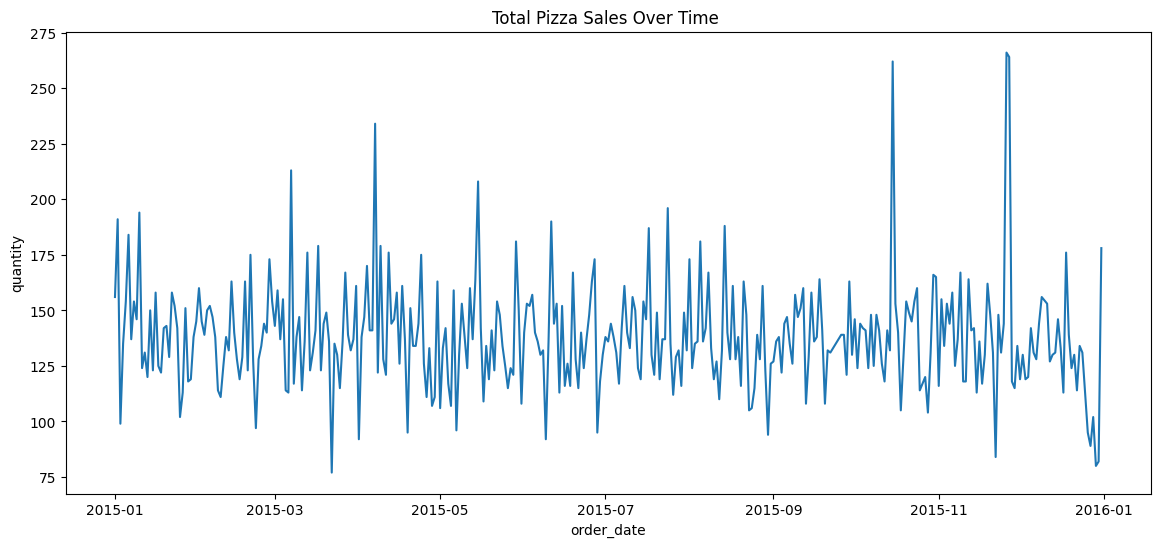

In [20]:
# line plot 

plt.figure(figsize=(14,6))
sns.lineplot(data=daily_sales.groupby('order_date')['quantity'].sum().reset_index(),x='order_date',y='quantity')
plt.title('Total Pizza Sales Over Time ')
plt.show()

## Top selling pizza 


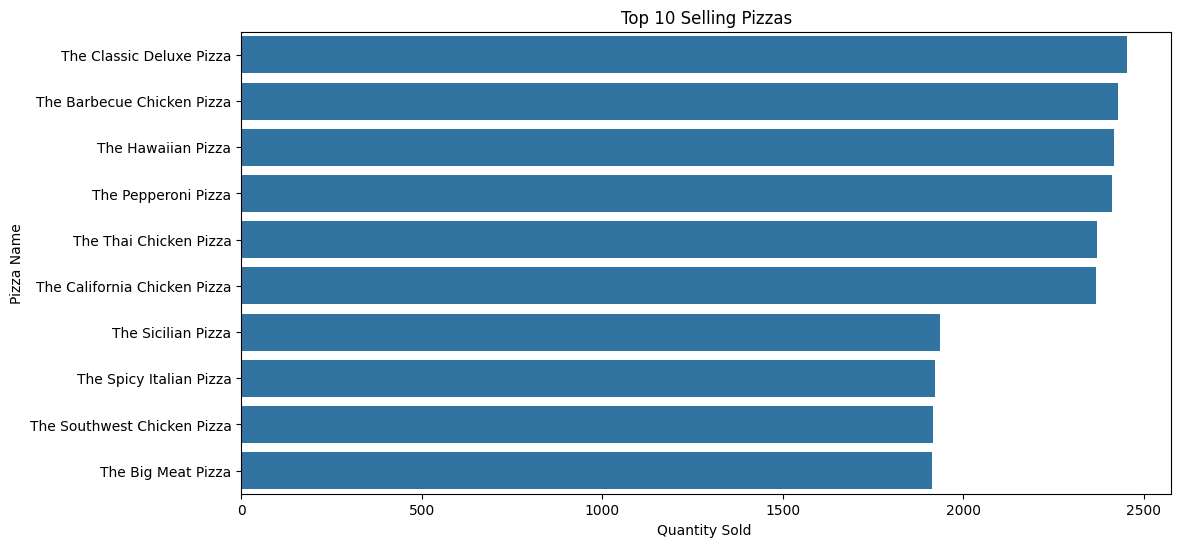

In [21]:
# group by pizza and callucate total sales 
top_pizzas = sales.groupby('pizza_name').agg({'quantity':'sum'}).sort_values(by='quantity',ascending=False)

#plot top selling pizza 

plt.figure(figsize=(12,6))
sns.barplot(x=top_pizzas['quantity'].head(10),y=top_pizzas.head(10).index)
plt.title('Top 10 Selling Pizzas')
plt.xlabel('Quantity Sold ')
plt.ylabel('Pizza Name')
plt.show()

## sales by day of week 

AttributeError: module 'matplotlib.pyplot' has no attribute 'xtixks'

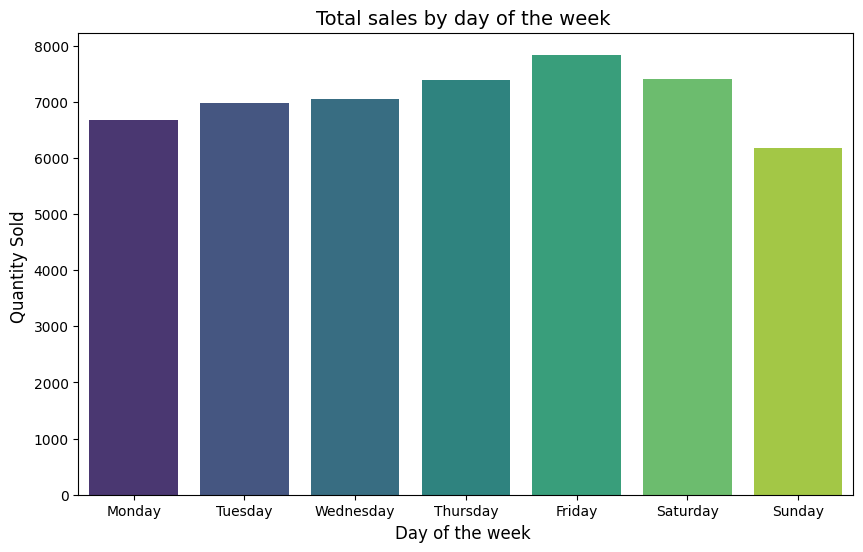

In [25]:
# add a daya if the week column

sales['day_of_week']=sales['order_date'].dt.day_name()

#group by day of the week 
sales_by_day = sales.groupby('day_of_week').agg({'quantity':'sum'}).reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

#plot sale by day of the week 

plt.figure(figsize=(10,6))
sns.barplot(x=sales_by_day.index, y=sales_by_day['quantity'],palette='viridis')
plt.title('Total sales by day of the week ',fontsize=14)
plt.xlabel('Day of the week ',fontsize=12)
plt.ylabel('Quantity Sold ',fontsize=12)
plt.xtixks(rotation=45)
plt.grid(alpha=0.3)
plt.show()

## Sales by Month 

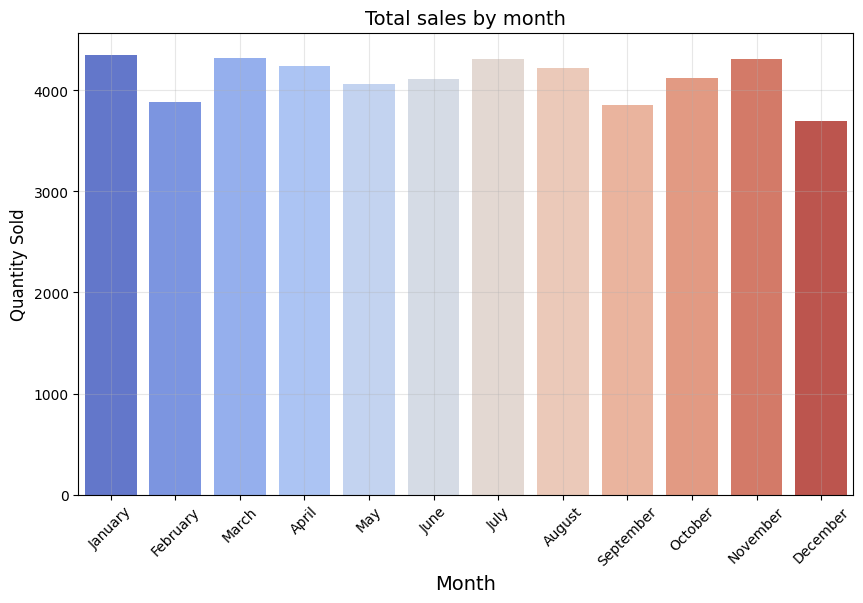

In [27]:
# add a month column 

sales['month']=sales['order_date'].dt.month_name()

#Groupby month 

sales_by_month=sales.groupby('month').agg({'quantity':'sum'}).reindex(['January','February','March','April','May','June','July','August','September','October','November','December'])

# plot sales by month 

plt.figure(figsize=(10,6))
sns.barplot(x=sales_by_month.index,y=sales_by_month['quantity'],palette='coolwarm')
plt.title('Total sales by month',fontsize=14)
plt.xlabel('Month',fontsize=14)
plt.ylabel('Quantity Sold',fontsize=12)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.show()